# Facebook videos analysis

Social media analysis is one of the most important tasks for every business that relies heavily on social media customers and content creators that wants to reach more audience.
In this project, I utilized some of my machine learning and visualization skills to gain more insights on a Facebook videos performance dataset.

# Dataset structure

The dataset consists of more than 1000 video records with 222 columns identifying different video metrics, unfortunately, I am not allowed to share the dataset publicly or to show the exact numbers of some metrics so some columns will be normalized on the graphs and some sensitive columns will be dropped.
The important features that will be used in this notebook:
* **Duration (sec)**: the duration of the video in seconds
* **Publish time**: the time when the video is published
* **Reach**: the number of unique people who saw the video
* **Likes**: the number of total reactions on the video
* **3-Second Video Views**: the number of times a video was played for at least three seconds
* **Percentage of Total Views at Interval 0-40**: these are 41 points equally split along the video duration to identify the viewers percentage that reached each point of the video
* **Estimated Earnings (USD)**: the amount of earnings the video made from in-stream video ads

In [40]:
%config Completer.use_jedi = False

In [41]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib notebook

In [42]:
DATA_PATH = 'data'

In [43]:
videos_data = pd.read_csv(os.path.join(DATA_PATH, 'Videos_16-Dec-2021.csv'), parse_dates=['Publish time'])

In [44]:
dropping_columns = ['Universal video ID', 'Page ID', 'Page name', 'Title']
videos_data.drop(dropping_columns, axis=1, inplace=True)
videos_data.head(1)

,Duration (sec),Publish time,Custom labels,Comment,Date,Impressions,Reach,Comments,Shares,Likes,...,Views by country (Czech Republic (CZ)),Estimated earnings by Live (USD),Views by country (Vietnam (VN)),Views by country (Colombia (CO)),Views by country (Serbia (RS)),Views by country (Croatia (HR)),Views by country (New Zealand (NZ)),Views by country (Bulgaria (BG)),Views by country (Thailand (TH)),Views by country (Portugal (PT))
0,595,2021-12-16 12:12:00,NaN,NaN,Lifetime,1586949,1492462,483,756,26770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Filtering & cleaning wrong recorded data

* Filtering out videos with a duration less than 15 sec or more than 16 min
* Filtering out early deleted videos (videos that have a very small number of likes, impressions, earnings, etc)
* Filtering out old videos before 19-7-2017

In [45]:
filtered_videos = videos_data[(videos_data['Duration (sec)'] > 15) & (videos_data['Duration (sec)'] < 16 * 60)]
filtered_videos = filtered_videos[filtered_videos['Publish time'] > pd.Timestamp(2017,7,19)]

## Optimizing video duration for video views

#### Identifying outliers

<IPython.core.display.Javascript object>


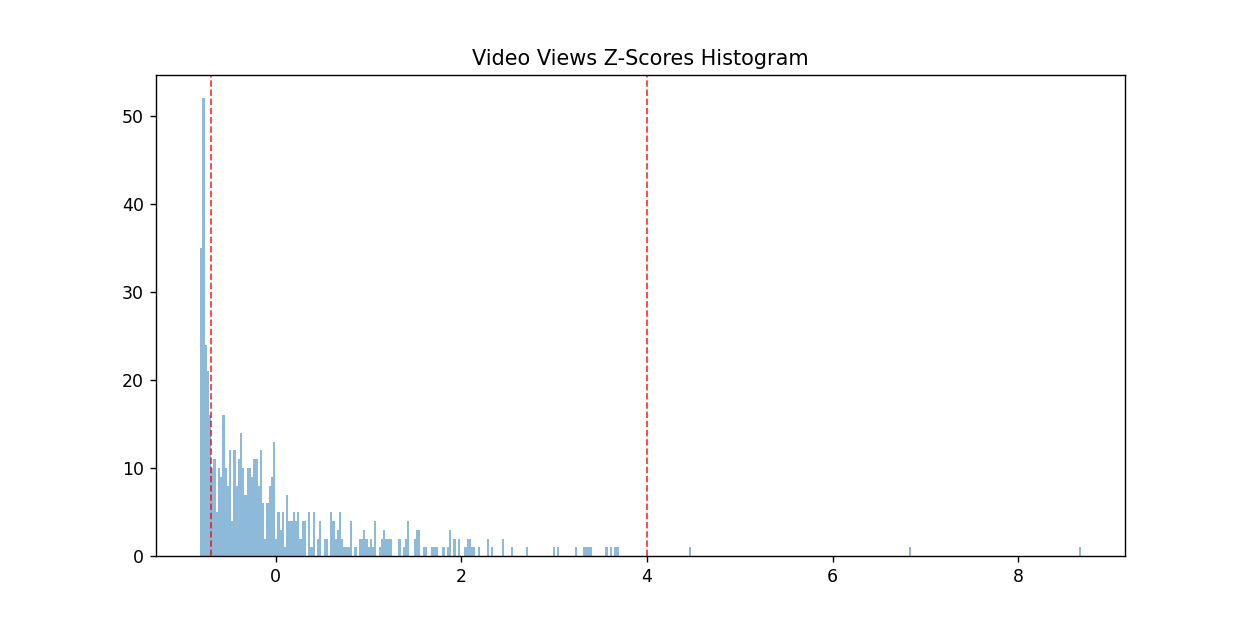

In [46]:
views_z_scores = stats.zscore(filtered_videos['3-Second Video Views'])
plt.figure(figsize=(10, 5))
plt.hist(views_z_scores, bins=400, alpha=0.5)
_ = plt.title("Video Views Z-Scores Histogram")

#### Removing outliers

In [47]:
upper_z_thresh = 4
lower_z_thresh = -0.7
views_filtered_videos = filtered_videos[(views_z_scores < upper_z_thresh) & (views_z_scores > lower_z_thresh)]
plt.axvline(x=upper_z_thresh, c='red', linestyle='--', alpha=0.8, linewidth=1)
plt.axvline(x=lower_z_thresh, c='red', linestyle='--', alpha=0.8, linewidth=1)

#### Normalizing views count

In [48]:
views_filtered_videos['3-Second Video Views'] = views_filtered_videos['3-Second Video Views'] / views_filtered_videos['3-Second Video Views'].max()

C:\Users\mohamed\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


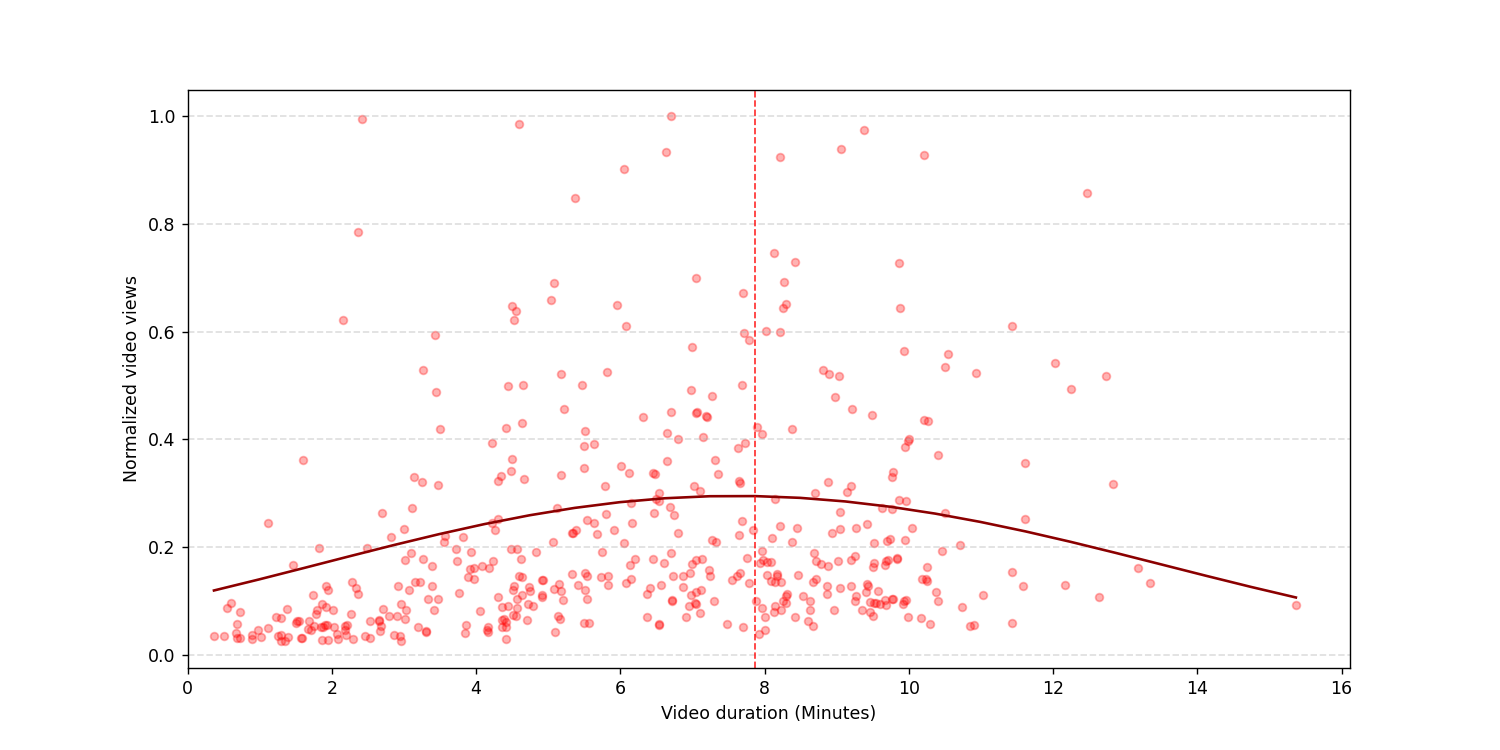

In [49]:
plt.figure(figsize=(12, 6))
plt.scatter(views_filtered_videos['Duration (sec)'] / 60, views_filtered_videos['3-Second Video Views'] , alpha=0.3, s=20, c='red')

num_bins = 25
x_smoothed = np.linspace(views_filtered_videos['Duration (sec)'].min(), views_filtered_videos['Duration (sec)'].max(), num_bins)
views_filtered_videos_grouped = views_filtered_videos[['Duration (sec)', '3-Second Video Views']].groupby('Duration (sec)').median()
spl = make_interp_spline(views_filtered_videos_grouped.index, views_filtered_videos_grouped['3-Second Video Views'], k=2)
y_smoothed = spl(x_smoothed)
y_smoothed = gaussian_filter1d(y_smoothed, sigma=6, mode="constant")
plt.plot(x_smoothed / 60, y_smoothed, color='darkred')

idxmax = np.where(y_smoothed == np.max(y_smoothed))
plt.axvline(x=x_smoothed[idxmax] / 60, c='red', linestyle='--', alpha=0.8, linewidth=1)

plt.ylabel("Normalized video views")
plt.xlabel("Video duration (Minutes)")

plt.gca().set_xlim(xmin=0)
plt.gca().grid(axis='y', linestyle='--', linewidth=1, alpha=0.4)

In [50]:
print('Best video duration for video views is around {}'.format(datetime.timedelta(seconds=int(x_smoothed[idxmax]))))

Best video duration for video views is around 0:07:52


## Optimizing video duration for watch percentage

<IPython.core.display.Javascript object>


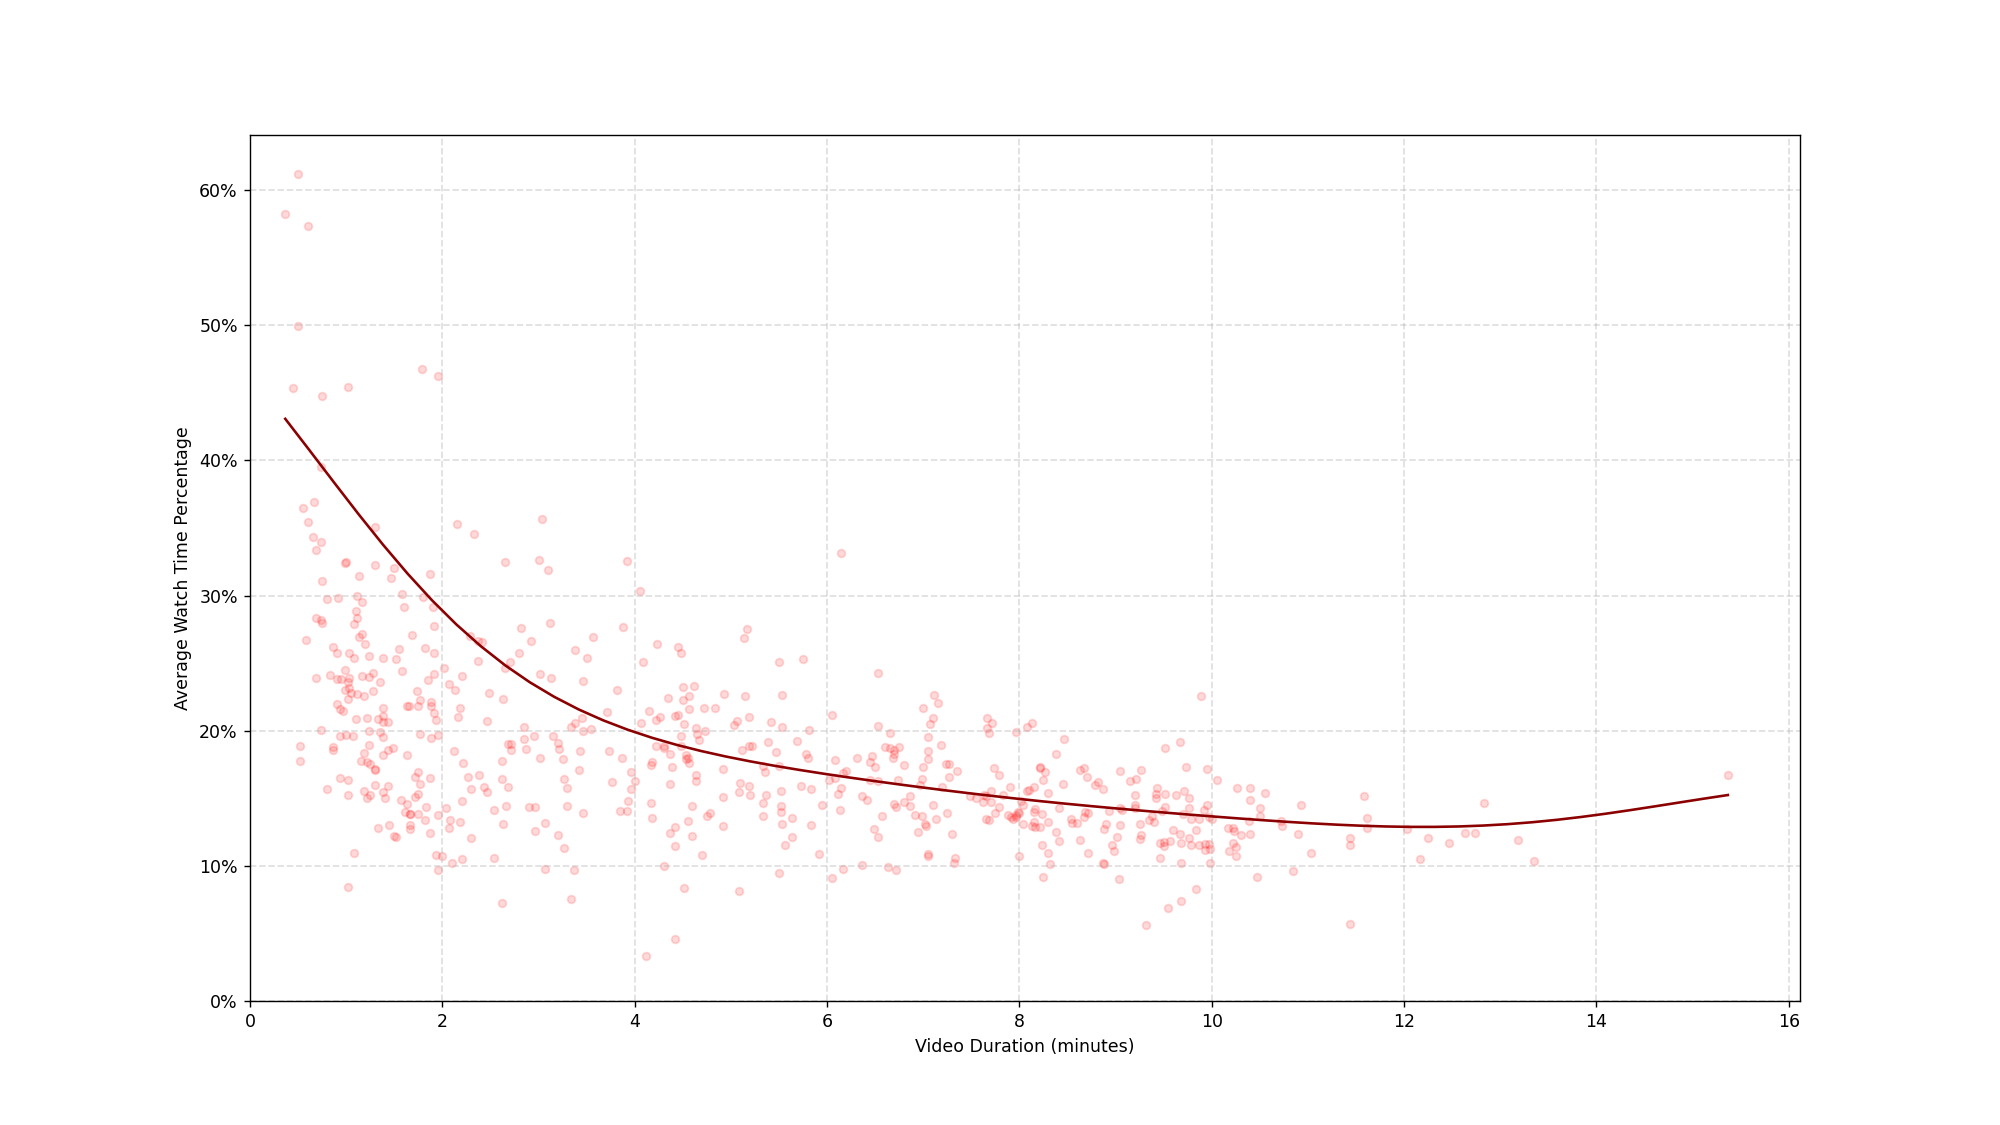

In [51]:
watch_pct_filtered_videos = filtered_videos.copy()
watch_pct_filtered_videos['watch_ratio'] = filtered_videos['Averaged Seconds Viewed'] / filtered_videos['Duration (sec)'] * 100
plt.figure(figsize=(16, 9))
plt.scatter(watch_pct_filtered_videos['Duration (sec)'] / 60, watch_pct_filtered_videos['watch_ratio'], alpha=0.15, s=20, c='red')
plt.xlabel("Video Duration (minutes)")
plt.ylabel("Average Watch Time Percentage")

filtered_videos_grouped = watch_pct_filtered_videos.groupby(['Duration (sec)']).median()

num_bins = 60
x_smoothed = np.linspace((filtered_videos_grouped.index / 60).min(), (filtered_videos_grouped.index / 60).max(), num_bins)
spl = make_interp_spline(filtered_videos_grouped.index / 60, filtered_videos_grouped['watch_ratio'], k=1)
y_smoothed = spl(x_smoothed)
y_smoothed = gaussian_filter1d(y_smoothed, sigma=6, mode="nearest")

plt.plot(x_smoothed, y_smoothed, color='darkred')

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())

plt.gca().set_xlim(xmin=0)
plt.gca().set_ylim(ymin=0)
plt.gca().grid(axis='both', linestyle='--', linewidth=1, alpha=0.4)

It is obvious from the plot that there is an exponential decay in average watch time as the video duration grows, it is better to keep the video length under 1:30 min to get more than 30% average watch time

## Optimizing video duration for video likes

#### Identifying outliers

<IPython.core.display.Javascript object>


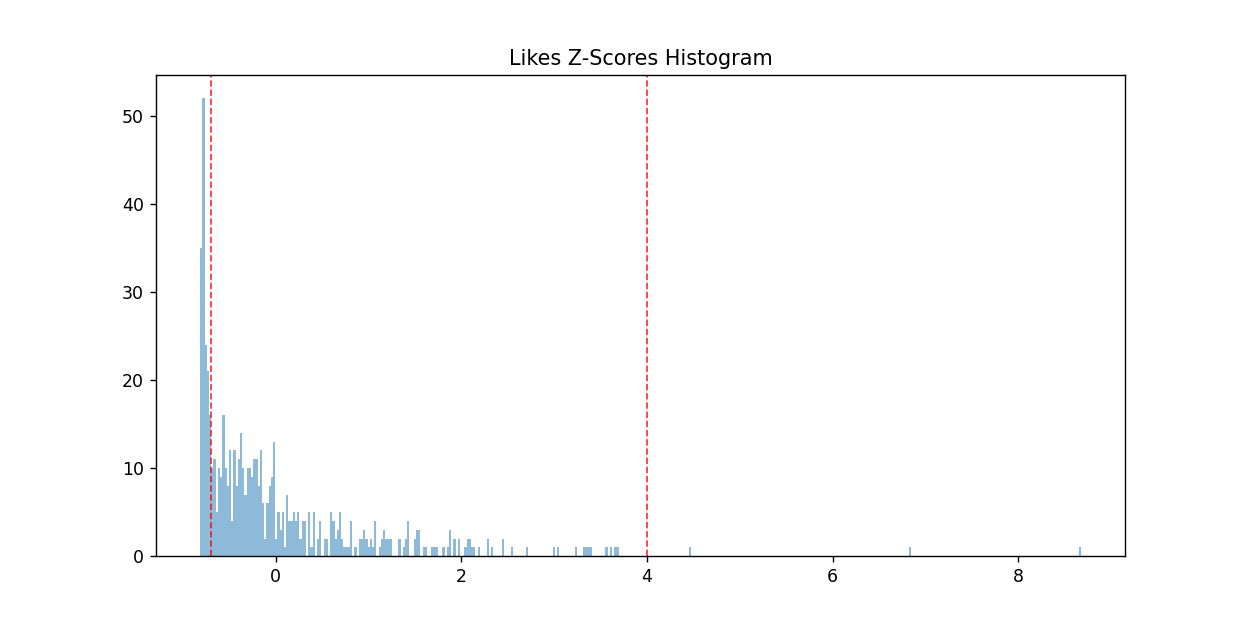

In [52]:
likes_z_scores = stats.zscore(filtered_videos['Likes'])
plt.figure(figsize=(10, 5))
plt.hist(views_z_scores, bins=400, alpha=0.5)
_ = plt.title("Likes Z-Scores Histogram")

#### Removing outliers

In [53]:
upper_z_thresh = 4
lower_z_thresh = -0.7
likes_filtered_videos = filtered_videos[(likes_z_scores < upper_z_thresh) & (likes_z_scores > lower_z_thresh)]
plt.axvline(x=upper_z_thresh, c='red', linestyle='--', alpha=0.8, linewidth=1)
plt.axvline(x=lower_z_thresh, c='red', linestyle='--', alpha=0.8, linewidth=1)

#### Normalizing likes

In [54]:
likes_filtered_videos['Likes'] = likes_filtered_videos['Likes'] / likes_filtered_videos['Likes'].max()

C:\Users\mohamed\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


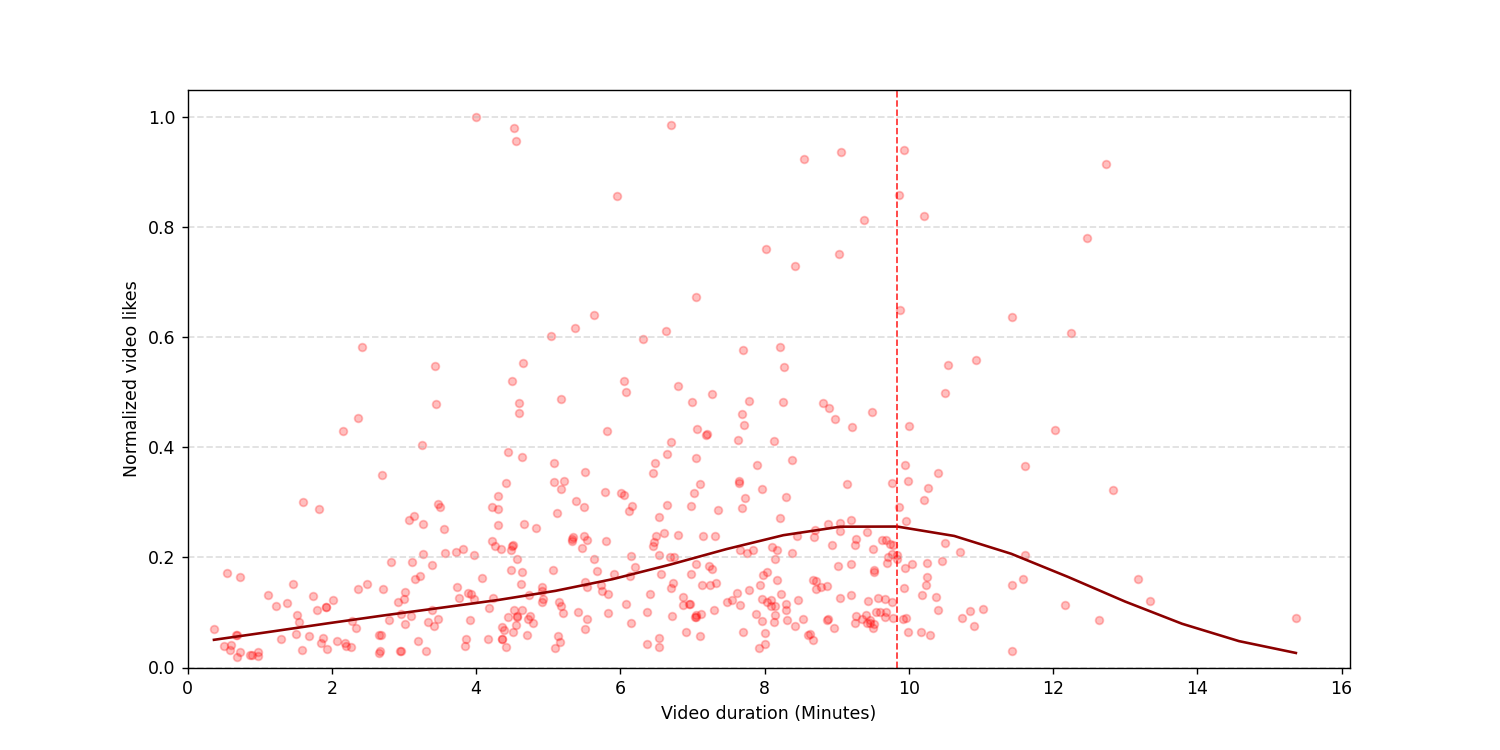

In [55]:
plt.figure(figsize=(12, 6))
plt.scatter(likes_filtered_videos['Duration (sec)'] / 60, likes_filtered_videos['Likes'], alpha=0.25, s=20, c='red')
plt.xlabel("Video duration (Minutes)")
plt.ylabel("Normalized video likes")

likes_filtered_videos_grouped = likes_filtered_videos.groupby(['Duration (sec)']).median()

num_bins = 20
x_smoothed = np.linspace(likes_filtered_videos_grouped.index.min(), likes_filtered_videos_grouped.index.max(), num_bins)
spl = make_interp_spline(likes_filtered_videos_grouped.index, likes_filtered_videos_grouped['Likes'], k=2)
y_smoothed = spl(x_smoothed)
y_smoothed = gaussian_filter1d(y_smoothed, sigma=3, mode="constant")

plt.plot(x_smoothed / 60, y_smoothed, color='darkred')

idxmax = np.where(y_smoothed == np.max(y_smoothed))
plt.axvline(x=x_smoothed[idxmax] / 60, c='red', linestyle='--', alpha=0.8, linewidth=1)

plt.gca().set_xlim(xmin=0)
plt.gca().set_ylim(ymin=0)
plt.gca().grid(axis='y', linestyle='--', linewidth=1, alpha=0.4)

In [56]:
print('Best video duration for the amount of likes is around {}'.format(datetime.timedelta(seconds=int(x_smoothed[idxmax]))))

Best video duration for the amount of likes is around 0:09:50


## Optimizing video duration for estimated earnings

In [57]:
monitized_videos = filtered_videos[filtered_videos['Estimated Earnings (USD)'] > 0]

#### Identifying outliers

<IPython.core.display.Javascript object>


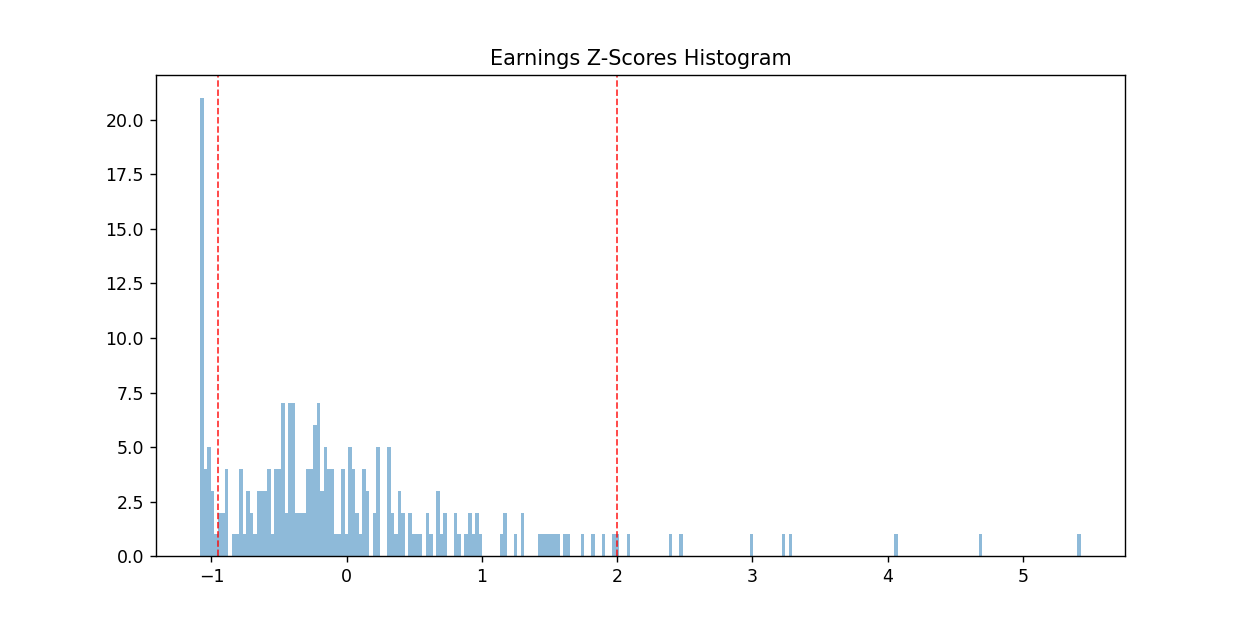

In [58]:
earnings_z_scores = stats.zscore(monitized_videos['Estimated Earnings (USD)'])
plt.figure(figsize=(10, 5))
plt.hist(earnings_z_scores, bins=250, alpha=0.5)
_ = plt.title("Earnings Z-Scores Histogram")

#### Removing outliers

In [59]:
upper_z_thresh = 2
lower_z_thresh = -0.95
filtered_monitized_videos = monitized_videos[(earnings_z_scores > lower_z_thresh) & ((earnings_z_scores < upper_z_thresh))]
plt.axvline(x=upper_z_thresh, c='red', linestyle='--', alpha=0.8, linewidth=1)
plt.axvline(x=lower_z_thresh, c='red', linestyle='--', alpha=0.8, linewidth=1)

#### Normalizing earnings

In [60]:
filtered_monitized_videos['Estimated Earnings (USD)'] = filtered_monitized_videos['Estimated Earnings (USD)'] / filtered_monitized_videos['Estimated Earnings (USD)'].max()

C:\Users\mohamed\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


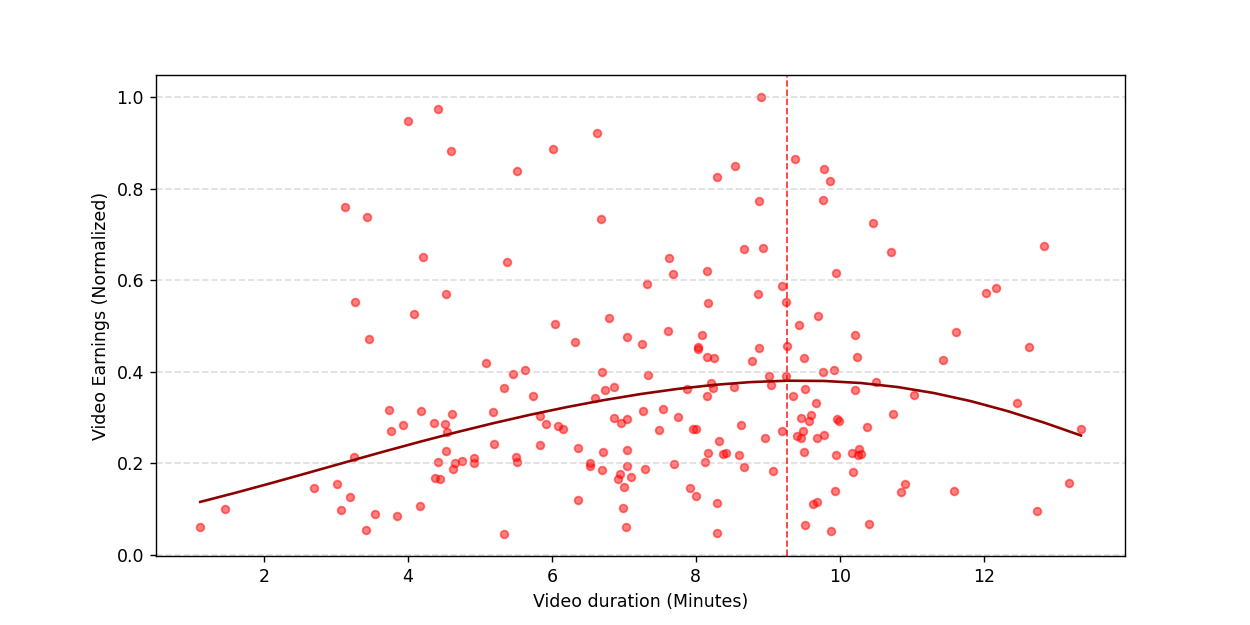

In [61]:
plt.figure(figsize=(10, 5))
plt.scatter(filtered_monitized_videos['Duration (sec)'] / 60, filtered_monitized_videos['Estimated Earnings (USD)'], alpha=0.5, s=20, c='red')

grouped_data = filtered_monitized_videos.groupby('Duration (sec)').median()
num_bins = 25
x_smoothed = np.linspace((grouped_data.index).min(), (grouped_data.index).max(), num_bins)
spl = make_interp_spline(grouped_data.index, grouped_data['Estimated Earnings (USD)'], k=2)
y_smoothed = spl(x_smoothed)
y_smoothed = gaussian_filter1d(y_smoothed, sigma=6, mode="constant")
plt.plot(x_smoothed / 60, y_smoothed, color='darkred')

idxmax = np.where(y_smoothed == np.max(y_smoothed))
plt.axvline(x=x_smoothed[idxmax] / 60, c='red', linestyle='--', alpha=0.8, linewidth=1)

plt.ylabel("Video Earnings (Normalized)")
plt.xlabel("Video duration (Minutes)")

plt.gca().grid(axis='y', linestyle='--', linewidth=1, alpha=0.4)

In [62]:
print('Best video duration for monitization is around {}'.format(datetime.timedelta(seconds=int(x_smoothed[idxmax]))))

Best video duration for monitization is around 0:09:16


## Distribution of estimated earnings

<IPython.core.display.Javascript object>


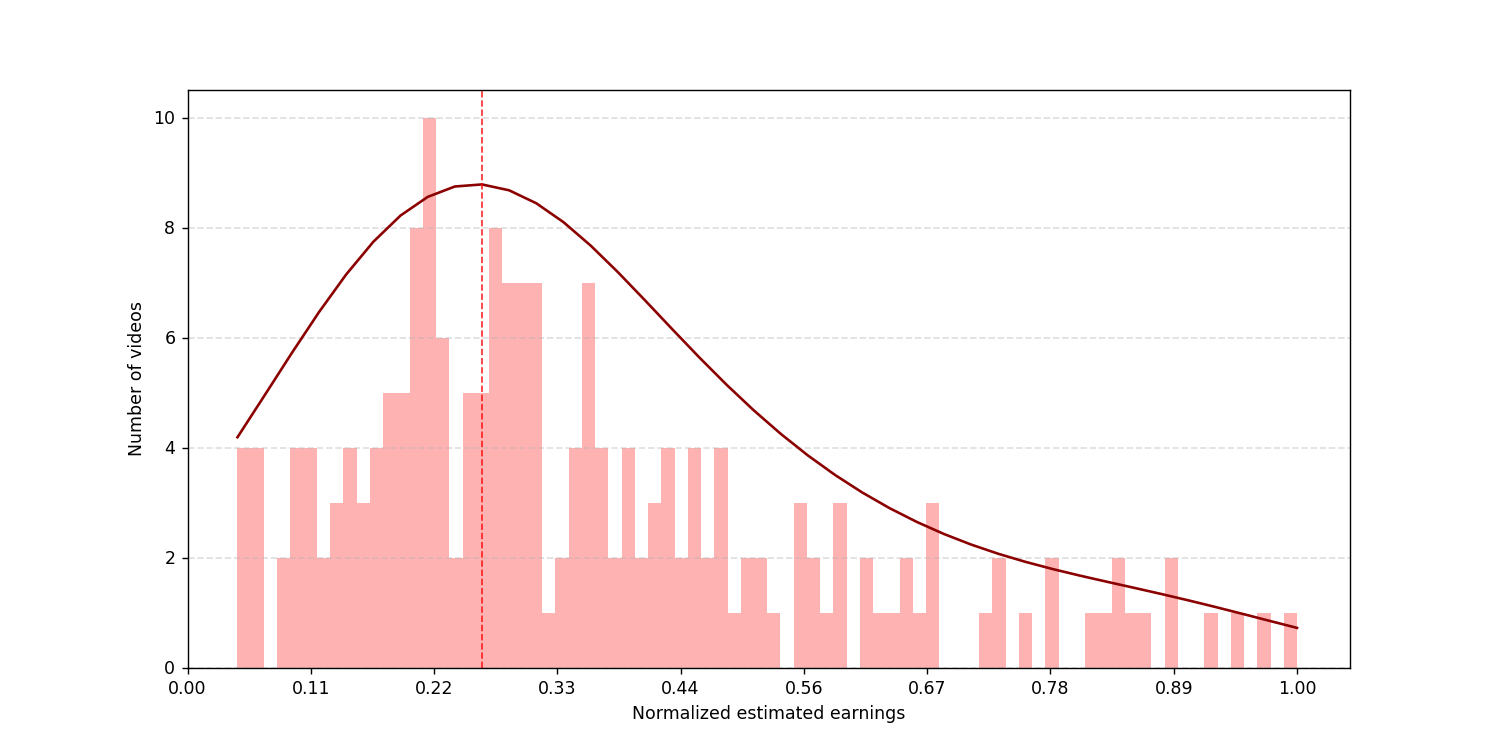

In [63]:
plt.figure(figsize=(12, 6))
plt.hist(filtered_monitized_videos['Estimated Earnings (USD)'], bins=80, color='red', alpha=0.3)

num_bins = 40
x_smoothed = np.linspace(filtered_monitized_videos['Estimated Earnings (USD)'].min(), filtered_monitized_videos['Estimated Earnings (USD)'].max(), num_bins)
spl = make_interp_spline(x_smoothed, np.histogram(filtered_monitized_videos['Estimated Earnings (USD)'], bins=num_bins)[0], k=2)
y_smoothed = spl(x_smoothed)
y_smoothed = gaussian_filter1d(y_smoothed, sigma=5, mode="constant")
plt.plot(x_smoothed, y_smoothed, color='darkred')

idxmax = np.where(y_smoothed == np.max(y_smoothed))
plt.axvline(x=x_smoothed[idxmax], c='red', linestyle='--', alpha=0.8, linewidth=1)

plt.xticks(np.linspace(0, filtered_monitized_videos['Estimated Earnings (USD)'].max(), 10))

x_fmt = ticker.FormatStrFormatter('%1.2f')
plt.gca().xaxis.set_major_formatter(x_fmt)

plt.xlabel("Normalized estimated earnings")
plt.ylabel("Number of videos")

plt.gca().set_xlim(xmin=0)
plt.gca().grid(axis='y', linestyle='--', linewidth=1, alpha=0.4)

In [64]:
print('Most common normalized estimated earnings for a single video is around {:.2f}'.format(float(x_smoothed[idxmax])))

Most common normalized estimated earnings for a single video is around 0.27


## Views source types

There are 3 main traffic sources for videos:
* Followers
* Facebook video suggestions
* Shares
Identifying traffic sources distribution is essential in making business decisions regarding social media platforms like putting marketing strategy, reaching more audience, etc

<IPython.core.display.Javascript object>


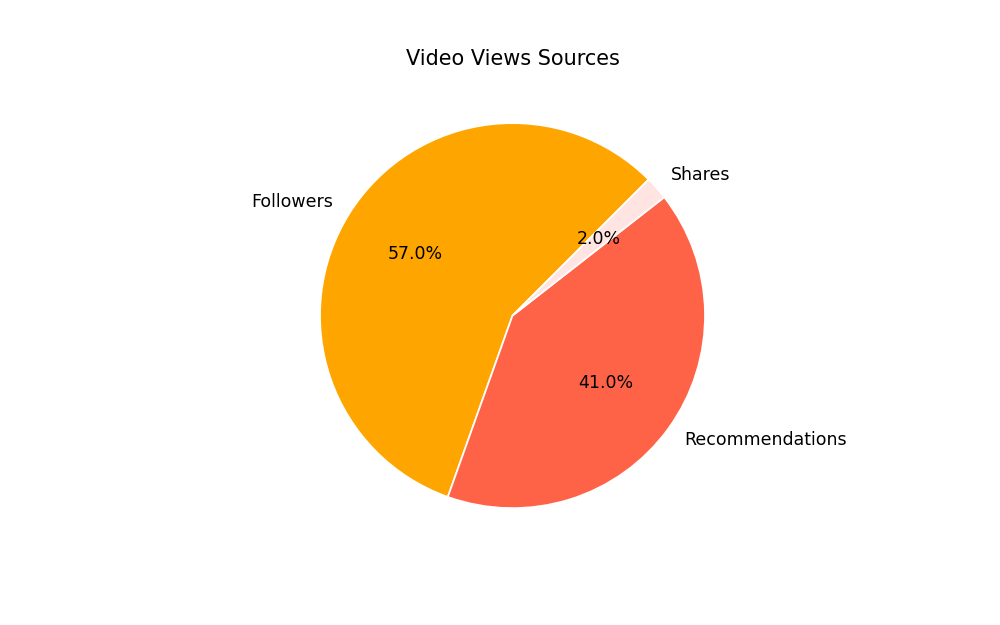

In [65]:
traffic_sources_names = ['60-Second Views From Followers',
                         '60-Second Views From Recommendations',
                         '60-Second Views From Shares']
traffic_sources_pct = filtered_videos[traffic_sources_names].apply(lambda x: x / x.sum() * 100, axis=1)
traffic_sources_pct_avg = traffic_sources_pct.mean()

labels = ['Followers', 'Recommendations', 'Shares']
colors = ['orange', 'tomato', 'mistyrose']
plt.figure(figsize=(8, 5))
plt.pie(traffic_sources_pct_avg, labels = labels, autopct='%1.1f%%', startangle=45, colors=colors,
        wedgeprops = {'linewidth': 1, 'edgecolor': 'white'})
_ = plt.title('Video Views Sources')

The graph shows that more than 40% of the viewers are from recommendations (viewers that have not yet liked or followed the page), there is a great opportunity to turn those viewers into followers!

## Audience retention case studies

The shape of the audience retention graph tells which parts of the video are most and least interesting to the viewers

<table align="left">
  <tr>
    <td><img src="imgs/chart_guide_flat_darkmode.svg" width = 100px></td>
    <td>When the line on the chart is flat, it means viewers are watching that part of your video from start to finish</td>
   </tr> 
  <tr>
    <td><img src="imgs/chart_guide_decline_darkmode.svg" width = 100px></td>
    <td>Gradual steep mean viewers are losing interest over time (this is the default behaviour from the audience)</td>
   </tr>
  <tr>
    <td><img src="imgs/chart_guide_bumps_darkmode.svg" width = 100px></td>
    <td>Spikes appear when more viewers are watching, rewatching or sharing those parts of the video</td>
   </tr>
  <tr>
    <td><img src="imgs/chart_guide_dips_darkmode.svg" width = 100px></td>
    <td>Dips mean viewers are abandoning or skipping at that specific part of the video</td>
   </tr> 
</table>

*Source: [YouTube Help](https://support.google.com/youtube/answer/9314415)*

The idea behind analyzing audience retention is to enhance upcoming video content by identifying viewers' preferences and specifying video portions that viewers liked most (where the line flattens) and the parts where viewers lost interest in continuing the video (where dips appear or rapid steep)
For that purpose a **multi-output regression** model is trained to capture average video performance and predict viewers percentage at different 41 points for any video, the input features for that model would be:
* video duration
* video reach
* video views

In [66]:
X_cols = ['Duration (sec)', 'Reach', '3-Second Video Views']
Y_cols = ['Percentage of Total Views at Interval {}'.format(i) for i in range(0, 41)]

In [67]:
filtered_videos_na_dropped = filtered_videos[X_cols+Y_cols].dropna(axis=0)
X = filtered_videos_na_dropped[X_cols]
Y = filtered_videos_na_dropped[Y_cols]

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

poly = PolynomialFeatures(2)
X_scaled = poly.fit_transform(X_scaled)

model = LinearRegression().fit(X_scaled, Y)

After building the model it is time to test it against some selected videos and compare the predicted performance with the actual performance

In [69]:
cases_idx = {'case1': 3,
             'case2': 21,
             'case3': 62}

In [70]:
def predict_cases(cases_idx, df, X_cols, Y_cols, model, scaler, poly_model):
    X = df.iloc[cases_idx][X_cols]
    X_scaled = scaler.transform(X)
    X_scaled = poly_model.transform(X_scaled)
    Y_pred = model.predict(X_scaled)
    return pd.DataFrame(data=Y_pred, columns=Y_cols, index=cases_idx)

In [71]:
Y = filtered_videos.iloc[[*cases_idx.values()]][Y_cols]

Y_pred = predict_cases([*cases_idx.values()], filtered_videos, X_cols, Y_cols, model, scaler, poly)
Y_pred.head()

,Percentage of Total Views at Interval 0,Percentage of Total Views at Interval 1,Percentage of Total Views at Interval 2,Percentage of Total Views at Interval 3,Percentage of Total Views at Interval 4,Percentage of Total Views at Interval 5,Percentage of Total Views at Interval 6,Percentage of Total Views at Interval 7,Percentage of Total Views at Interval 8,Percentage of Total Views at Interval 9,...,Percentage of Total Views at Interval 31,Percentage of Total Views at Interval 32,Percentage of Total Views at Interval 33,Percentage of Total Views at Interval 34,Percentage of Total Views at Interval 35,Percentage of Total Views at Interval 36,Percentage of Total Views at Interval 37,Percentage of Total Views at Interval 38,Percentage of Total Views at Interval 39,Percentage of Total Views at Interval 40
3,0.974467,0.450447,0.377518,0.336610,0.297622,0.256947,0.230344,0.205768,0.188351,0.173070,...,0.057812,0.056580,0.054830,0.053851,0.052381,0.051204,0.049765,0.047438,0.045225,0.046033
21,0.982432,0.778859,0.608030,0.511290,0.456345,0.419662,0.390434,0.366245,0.347642,0.332904,...,0.200281,0.197150,0.193698,0.191039,0.187446,0.183723,0.179602,0.175285,0.169305,0.136110
62,0.978952,0.677034,0.511720,0.439745,0.400301,0.369333,0.342052,0.317736,0.299349,0.284950,...,0.154158,0.151274,0.148584,0.146521,0.143440,0.140400,0.136800,0.133404,0.128804,0.107358


In [72]:
from datetime import datetime
from matplotlib import dates

def get_case_numeric_timestamp(duration_sec):
    timestamps = [datetime.fromtimestamp(duration_sec * i / 40).strftime('%Y-%m-%d %H:%M:%S') for i in range(0, 41)]
    return dates.date2num(timestamps)

In [73]:
cases_numeric_timestamps = [get_case_numeric_timestamp(i) for i in filtered_videos.iloc[[*cases_idx.values()]]['Duration (sec)']]

In [74]:
def plot_case(numeric_timestamp, Y, Y_pred, case_number):
    plt.figure(figsize=(12, 6))

    plt.plot(numeric_timestamp, Y_pred * 100, alpha=0.4, c='darkblue')
    plt.plot(numeric_timestamp, Y * 100, c='darkred')

    formatter = dates.DateFormatter('%M:%S')
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())

    plt.xticks([tick for i, tick in enumerate(numeric_timestamp) if i%4==0 and i!=0])
    
    plt.title('Audience Retention - Case #{}'.format(case_number + 1))
    plt.legend(['Expected Performance', 'Video Performance'])
    plt.xlabel("Timestamp")
    plt.ylabel("Viewers Percentage")
    
    plt.gca().set_xlim(xmin=dates.date2num(datetime.fromtimestamp(0)))
    plt.gca().set_ylim(ymin=0)
    
    plt.gca().grid(axis='y', linestyle='--', linewidth=1, alpha=0.3)

### Case 1

<IPython.core.display.Javascript object>


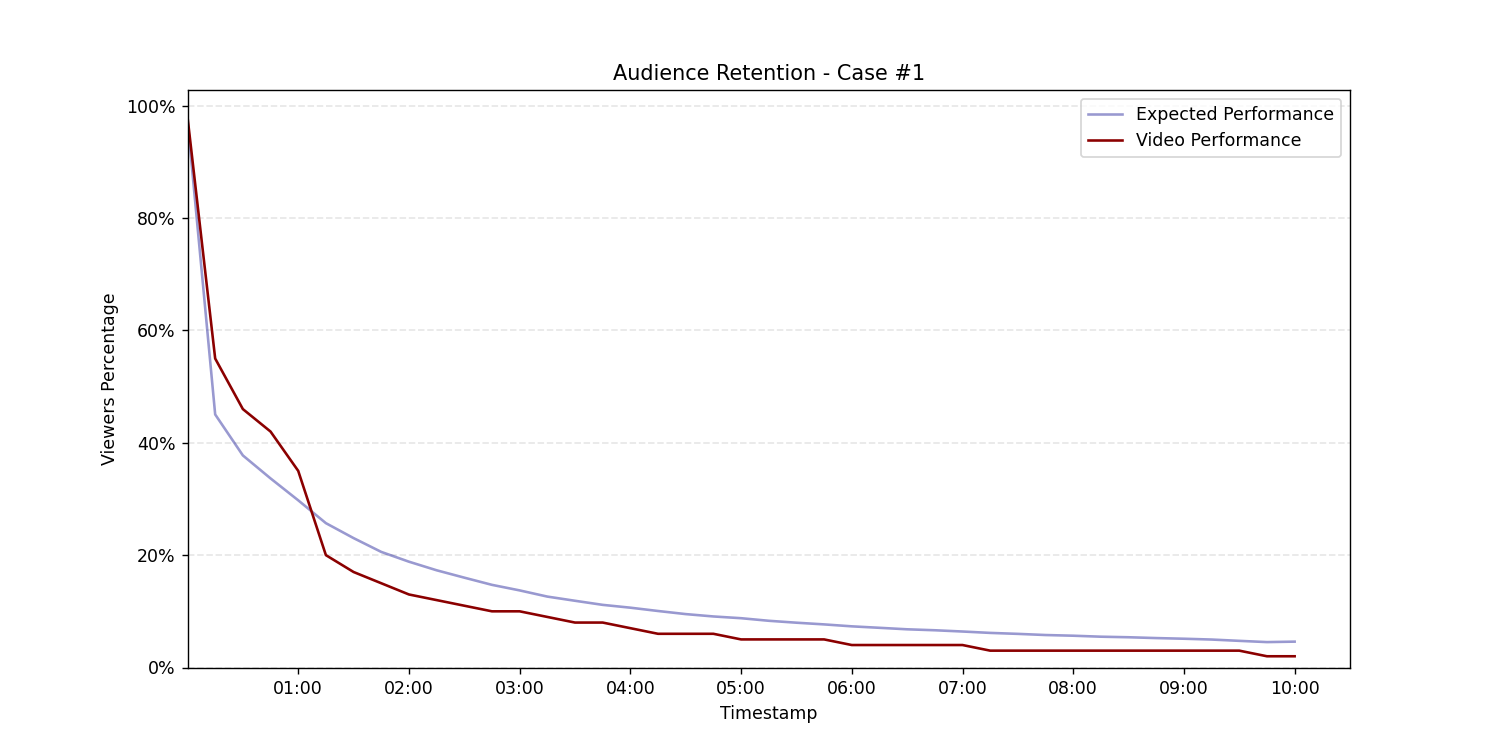

In [75]:
case_num = 0
plot_case(cases_numeric_timestamps[case_num], Y.iloc[case_num], Y_pred.iloc[case_num], case_num)

It is clear from the graph that the actual video performance outperformed the expected performance generated by the trained model before 01:00 then there is a huge dip at 01:14

### Case 2

<IPython.core.display.Javascript object>


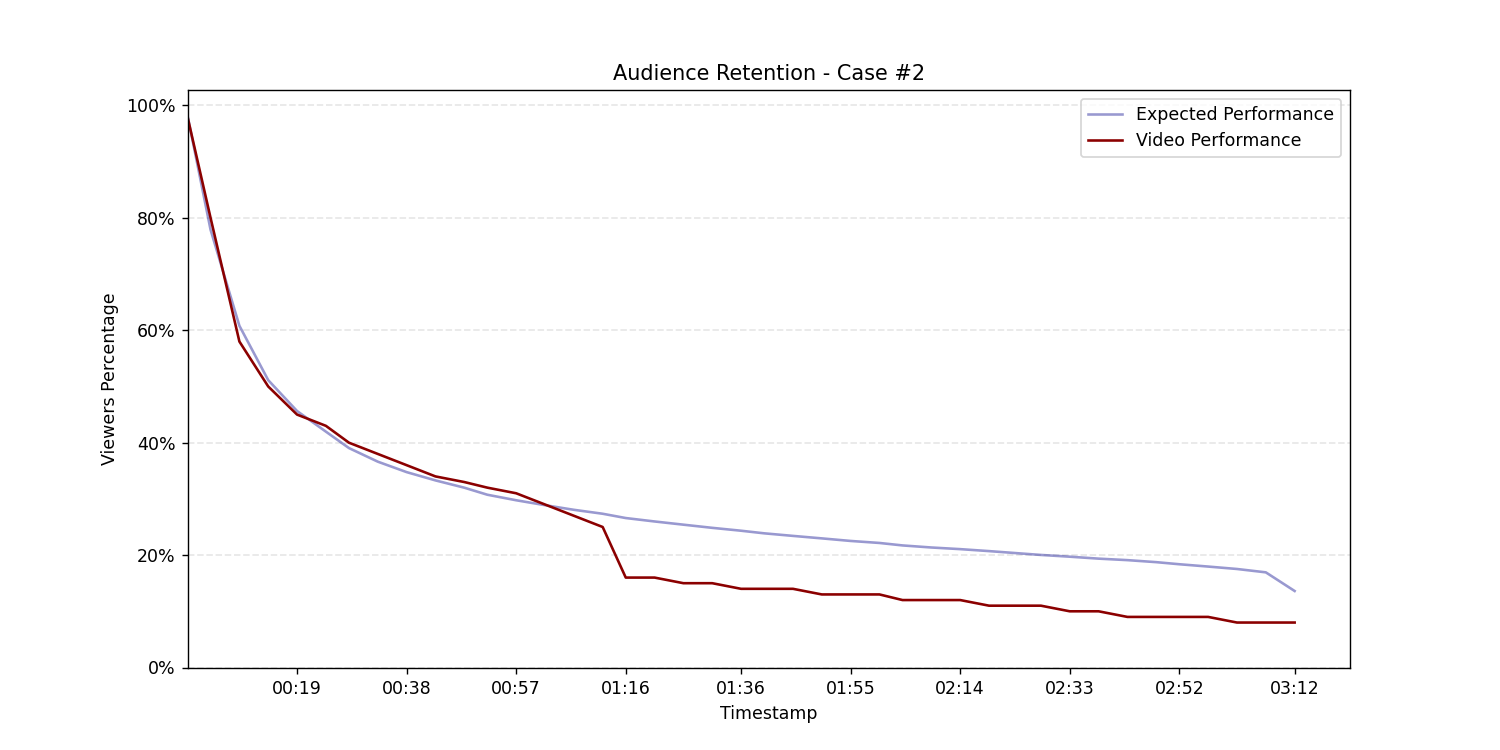

In [76]:
case_num = 1
plot_case(cases_numeric_timestamps[case_num], Y.iloc[case_num], Y_pred.iloc[case_num], case_num)

The video performance was going as expected before 01:12 then there is a huge dip at 01:16 causing the performance to be worse than expected until the end of the video

### Case 3

<IPython.core.display.Javascript object>


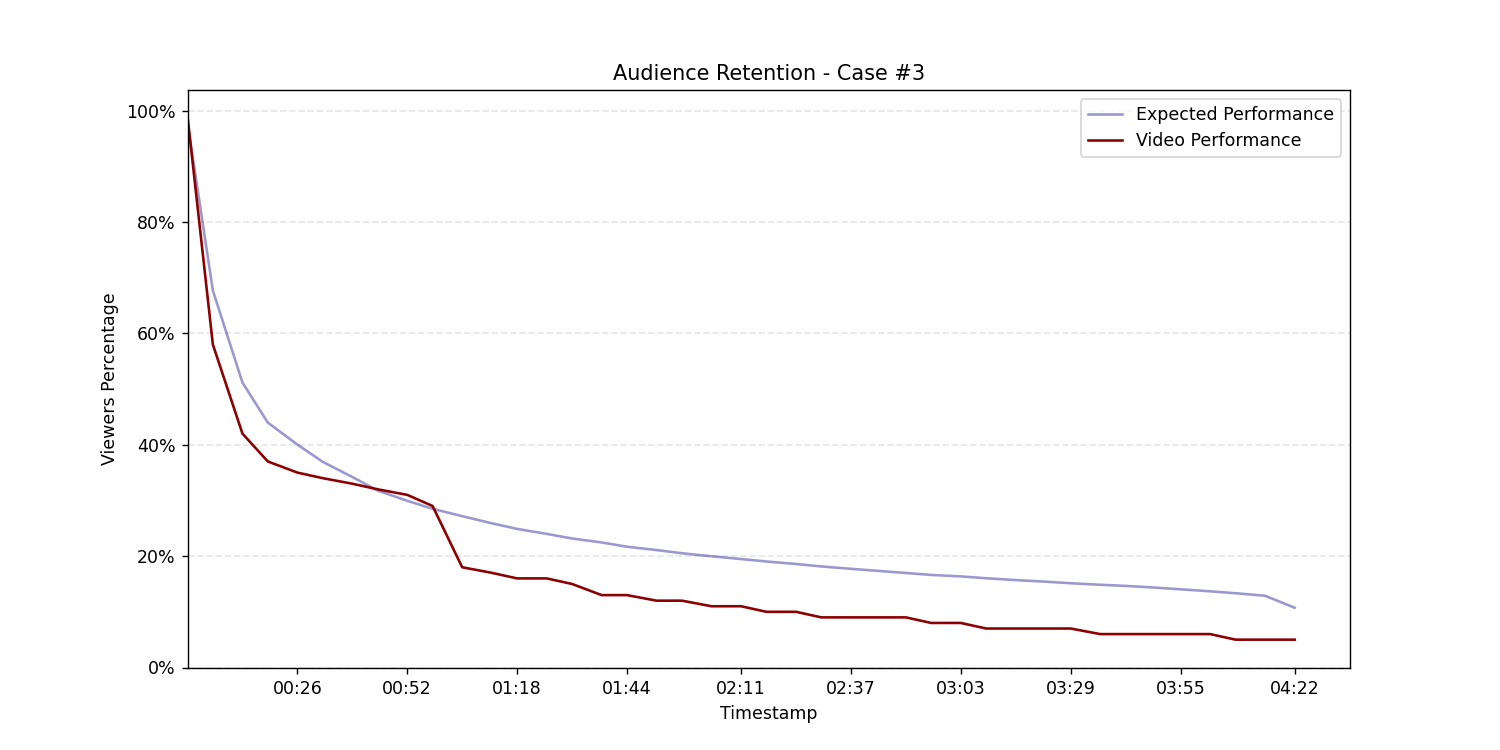

In [77]:
case_num = 2
plot_case(cases_numeric_timestamps[case_num], Y.iloc[case_num], Y_pred.iloc[case_num], case_num)

The video performance was going worse than expected from the start of the video until 00:19 the line started to flatten and retain viewers' attention till 00:57 then a huge dip at 01:15 caused the performance to be worse than expected till the end of the video